Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import cifar100

from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

%matplotlib inline

Extract data and train and test dataset

In [2]:
#cifar100 = tf.keras.datasets.cifar100
(X_train,Y_train) , (X_test,Y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 6s 0us/step


In [27]:
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',                'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',                'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup',                'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house',                'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man',                'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid',                'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',                'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew',                'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper',                'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',                'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']


Let's look into the dataset images

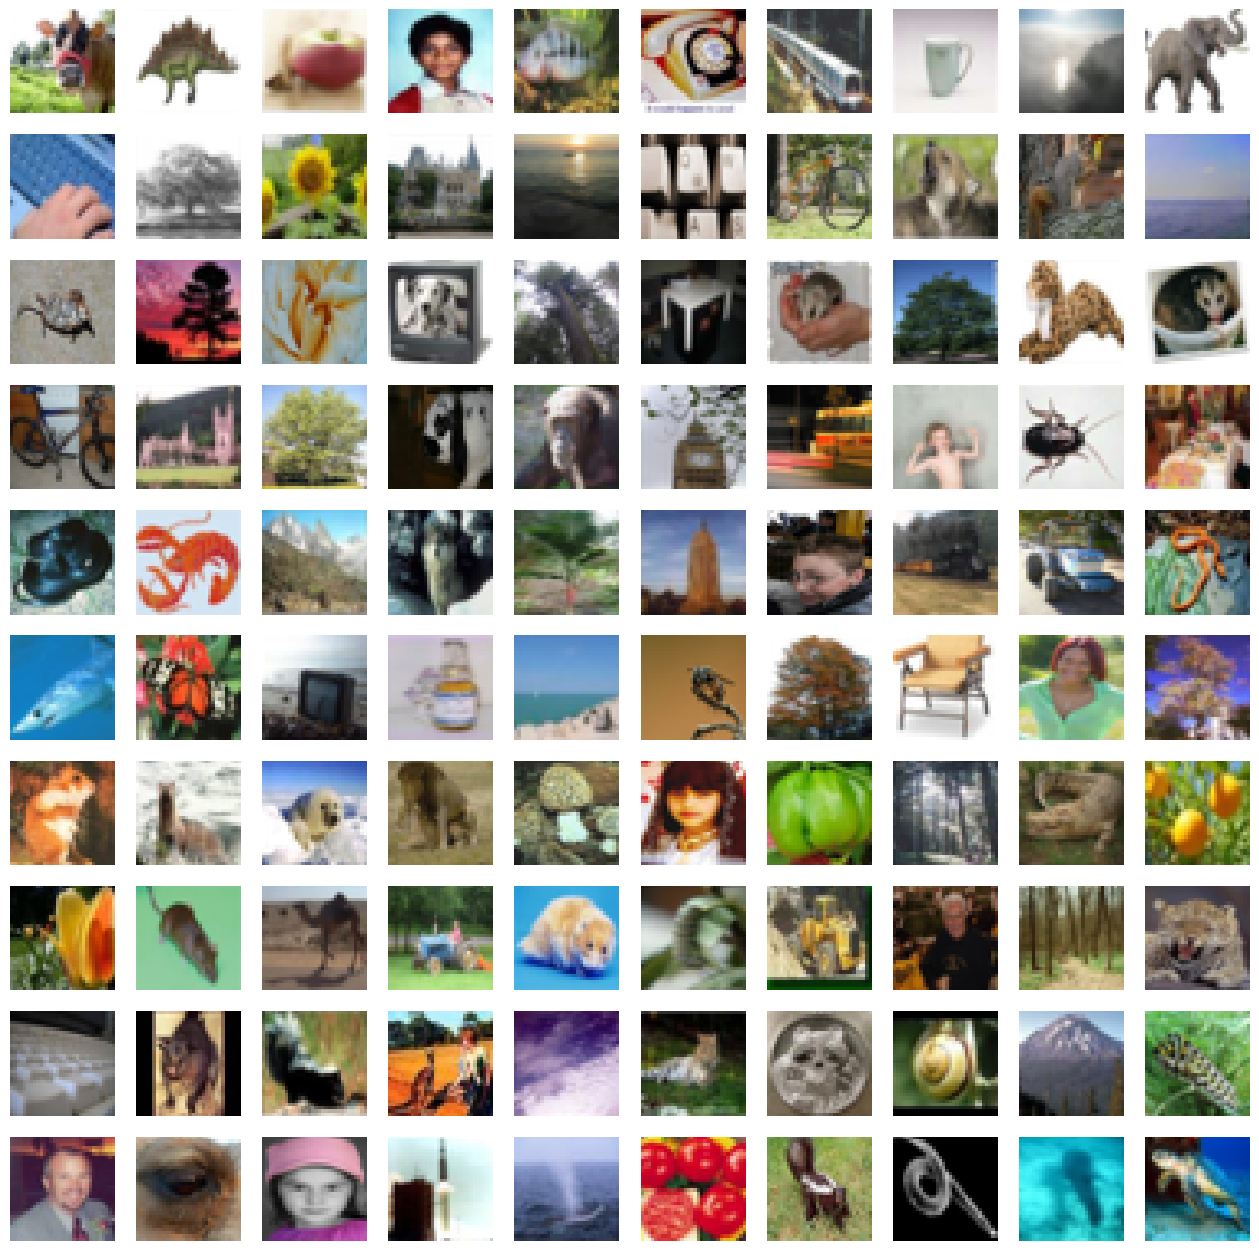

In [3]:
plt.figure(figsize = (16,16))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.imshow(X_train[i], cmap = 'gray')

Training , Validating and Splitting trained and tested data

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,test_size=0.2)

In [6]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(40000, 32, 32, 3)
(40000, 100)
(10000, 32, 32, 3)
(10000, 100)
(10000, 32, 32, 3)
(10000, 1)


In [8]:
train_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    horizontal_flip = True
)
train_datagen.fit(x_train)

val_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg19.preprocess_input)
val_datagen.fit(x_val)

In [9]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

We have used only 16 layers out of 19 layers in the CNN

In [10]:
vgg_model = tf.keras.applications.VGG19(
    include_top=False,
    weights=None,
    input_shape=(32,32,3),
)

vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [14]:
model = tf.keras.Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_3 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 1024)              1049600   
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                      

In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9)
model.compile(optimizer= optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [16]:
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size = 128),
    validation_data = val_datagen.flow(x_val,y_val, batch_size = 128),
    epochs = 10,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)

Epoch 1/10
313/313 [==============================] - 44s 124ms/step - loss: 5.2395 - accuracy: 0.0140 - val_loss: 4.5463 - val_accuracy: 0.0205 - lr: 0.0010
Epoch 2/10
313/313 [==============================] - 38s 121ms/step - loss: 5.0465 - accuracy: 0.0181 - val_loss: 4.5047 - val_accuracy: 0.0240 - lr: 0.0010
Epoch 3/10
313/313 [==============================] - 36s 116ms/step - loss: 4.9621 - accuracy: 0.0179 - val_loss: 4.7844 - val_accuracy: 0.0117 - lr: 0.0010
Epoch 4/10
313/313 [==============================] - 36s 115ms/step - loss: 4.8896 - accuracy: 0.0191 - val_loss: 4.5794 - val_accuracy: 0.0206 - lr: 0.0010
Epoch 5/10
313/313 [==============================] - 36s 116ms/step - loss: 4.7757 - accuracy: 0.0202 - val_loss: 4.4016 - val_accuracy: 0.0302 - lr: 0.0010
Epoch 6/10
313/313 [==============================] - 36s 116ms/step - loss: 4.6797 - accuracy: 0.0253 - val_loss: 4.3797 - val_accuracy: 0.0325 - lr: 0.0010
Epoch 7/10
313/313 [==============================] 

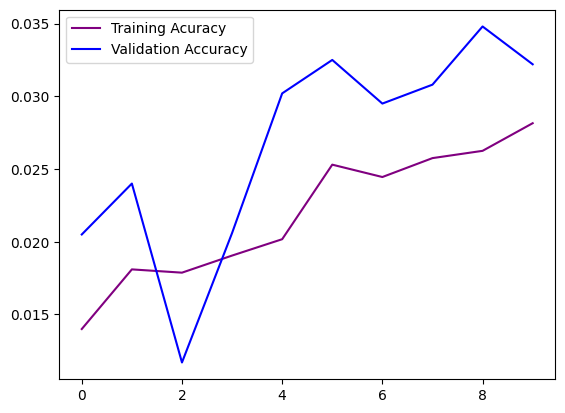

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure()
plt.plot(acc,color = 'purple',label = 'Training Acuracy')
plt.plot(val_acc,color = 'blue',label = 'Validation Accuracy')
plt.legend()

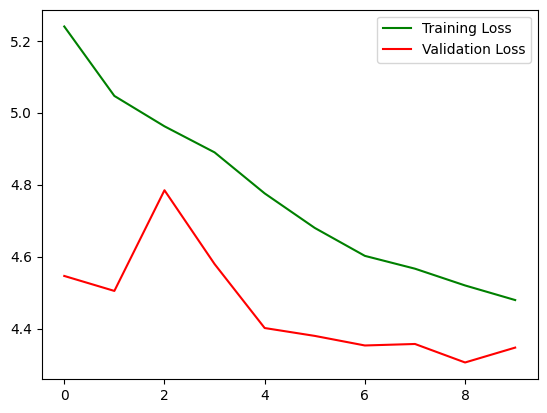

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss,color = 'green',label = 'Training Loss')
plt.plot(val_loss,color = 'red',label = 'Validation Loss')
plt.legend()

In [19]:
X_test = tf.keras.applications.vgg19.preprocess_input(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)

y_pred[:10]

313/313 [==============================] - 3s 9ms/step


array([53, 77, 36,  5, 87, 77, 77, 77, 52, 82])

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score
print('Testing Accuarcy : ', accuracy_score(Y_test, y_pred))

Testing Accuarcy :  0.0303


In [21]:
cm = confusion_matrix(Y_test, y_pred)
cm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [30]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
plt.figure(figsize=(100,100))
plot_confusion_matrix(cm,classes)

Normalized confusion matrix


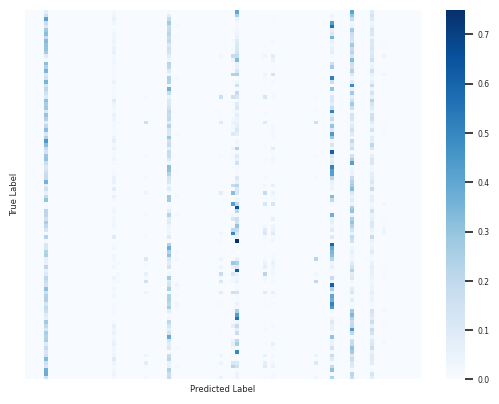

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# assume y_true and y_pred are the true and predicted labels, respectively
# you can obtain them from your model's predictions on a validation set

# calculate the confusion matrix
confusion_matrix = np.zeros((100, 100))
for i in range(len(Y_test)):
    confusion_matrix[Y_test[i], y_pred[i]] += 1

# normalize the confusion matrix
confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=False)

# create a heatmap using seaborn
sns.set(font_scale=0.5)  # adjust font size to fit more labels
sns.heatmap(confusion_matrix, cmap='Blues', annot=False, xticklabels=False, yticklabels=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()